In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, spherical_to_cartesian
import tools

weighted least-squares : $ X = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y ] $

### $Y$ : QUaia raw counts

In [3]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
map_quaia = tools.load_catalog_as_map(cat_fn, frame='icrs')

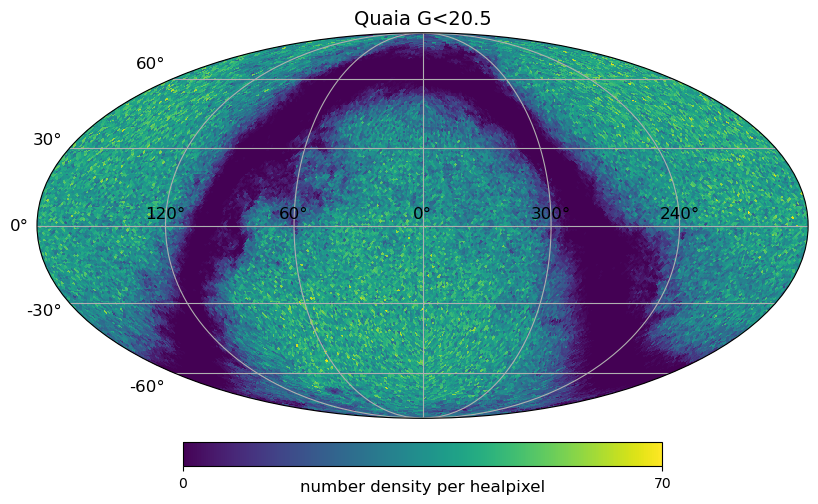

In [4]:
tools.plot_map(map_quaia, title=f'Quaia G<{G}', unit='number density per healpixel')

### $A$ : design matrix : selection function * expected dipole (CMB)

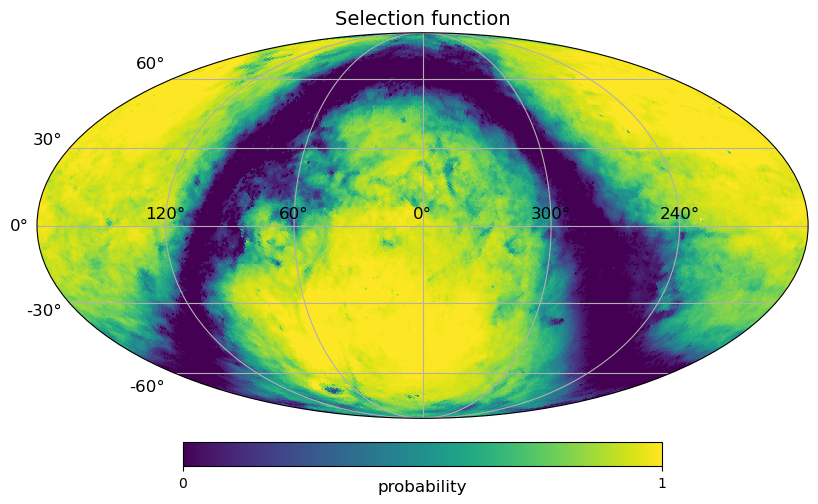

In [5]:
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
tools.plot_map(selfunc, title='Selection function', unit='probability')

In [6]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


In [7]:
# dipole amplitudes: zero mean for now
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(amps, NSIDE) # match NSIDE with Quaia map

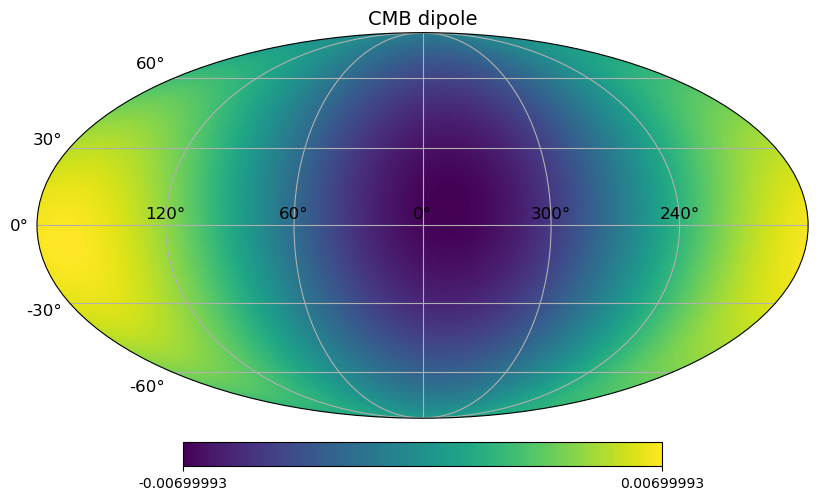

In [8]:
tools.plot_map(expected_map, title='CMB dipole')

In [9]:
# construct design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree

### $C^{-1}$ : weights = completeness

In [10]:
Cinv = np.diag(selfunc)

### perform the regression !

In [11]:
b, m = tools.lstsq(map_quaia, A, Cinv)
b, m

(41.06267705322663, 64.79480768514367)

In [12]:
m/b # --> gives us the dipole amplitude !

1.5779489389148877

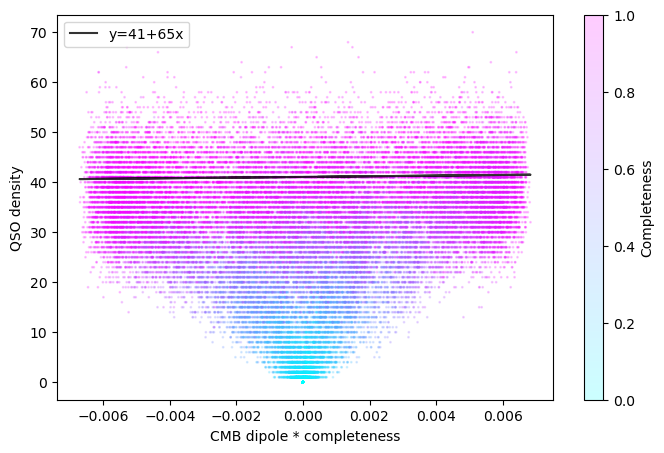

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
s = ax.scatter(A[:,1], map_quaia, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
ax.plot(A[:,1], b+m*A[:,1], color='k', alpha=0.8, label=f'y={b:.0f}+{m:.0f}x', zorder=100)
ax.set_xlabel('CMB dipole * completeness')
ax.set_ylabel('QSO density')
# ax.set_title('Dipole fit to Quaia catalog')
ax.legend()
fig.colorbar(s, label='Completeness')

### check that trivial cases match np.polyfit result

#### QUaia / completeness; no weights

In [14]:
# polyfit
map_quaia_expected = map_quaia / selfunc
idx_to_fit = np.where(~np.isnan(map_quaia_expected))
print(len(idx_to_fit[0])/len(map_quaia_expected))
mp, bp = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1)
bp, mp

0.8718465169270834


/state/partition1/job-35458696/ipykernel_3597164/2994900404.py:2: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


(40.34242278063612, 93.22629854390141)

In [15]:
# mine
Y = map_quaia_expected[idx_to_fit]
A = np.column_stack((np.ones_like(Y), expected_map[idx_to_fit]))
Cinv = np.identity(len(Y))
tools.lstsq(Y, A, Cinv)

array([40.34242278, 93.22629854])

#### QUaia / completeness; weight by completeness

In [16]:
# polyfit
map_quaia_expected = map_quaia / selfunc
idx_to_fit = np.where(~np.isnan(map_quaia_expected))
print(len(idx_to_fit[0])/len(map_quaia_expected))
mp, bp = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1, w=np.sqrt(selfunc[idx_to_fit]))
bp, mp

0.8718465169270834


/state/partition1/job-35458696/ipykernel_3597164/934415296.py:2: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


(40.88933375279304, 72.61503135799234)

In [17]:
# construct matrices
Y = map_quaia_expected[idx_to_fit]
A = np.column_stack((np.ones_like(Y), expected_map[idx_to_fit]))
Cinv = np.diag(selfunc[idx_to_fit])
tools.lstsq(Y, A, Cinv)

array([40.88933375, 72.61503136])

### Secrest cuts

In [18]:
# cut around galactic plane |b|<30deg
map_quaia_gal = tools.load_catalog_as_map(cat_fn, frame='galactic')
l, b = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)
map_quaia_galcut = np.copy(map_quaia_gal).astype(float)
blim = 30
galmask = (np.abs(b)<blim)
map_quaia_galcut[galmask] = np.nan

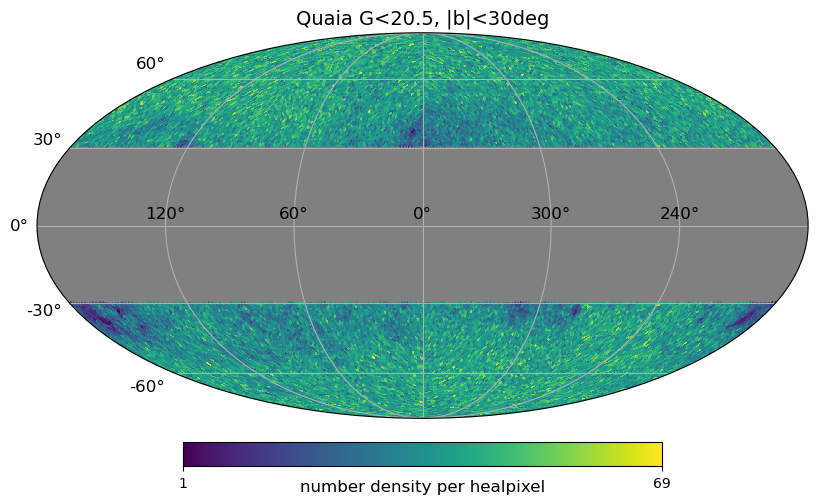

In [19]:
tools.plot_map(map_quaia_galcut, title=f'Quaia G<{G}, |b|<{blim}deg', unit='number density per healpixel')

In [20]:
# expected map in galactic coords
# dipole amplitudes: zero mean for now
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.b.rad,
                                             phi=cmb_dipdir.l.rad)])
expected_map_gal = dipole_map(amps, NSIDE) # match NSIDE with Quaia map

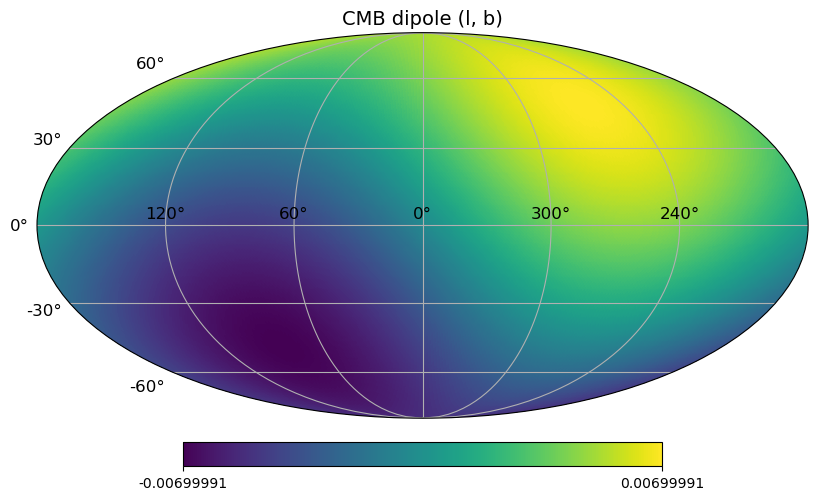

In [21]:
tools.plot_map(expected_map_gal, title='CMB dipole (l, b)')

In [22]:
# fit
Y = map_quaia_gal[~galmask]
A = np.column_stack((np.ones_like(Y), expected_map_gal[~galmask]))
# Cinv = np.diag(selfunc[~galmask])
Cinv = np.identity(len(Y))
bsec, msec = tools.lstsq(Y, A, Cinv)

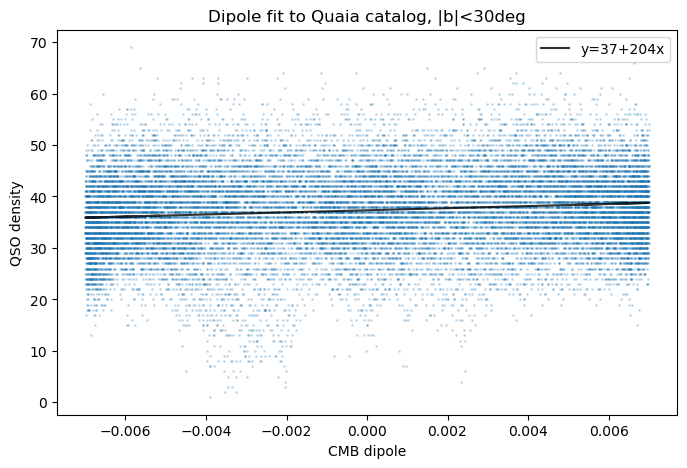

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
s = ax.scatter(A[:,1], map_quaia_gal[~galmask], marker='.', s=4, ls='None', alpha=0.2)
ax.plot(A[:,1], bsec+msec*A[:,1], color='k', alpha=0.8, label=f'y={bsec:.0f}+{msec:.0f}x', zorder=100)
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO density')
ax.set_title(f'Dipole fit to Quaia catalog, |b|<{blim}deg')
ax.legend()